# Stock Chart Pattern Recognition with Deep Learning
## CRISP-DM Methodology

🔵 Phase 1: Business Understanding
Cell 1: Business Objective

เป้าหมาย: สร้างระบบตรวจจับรูปแบบ Head & Shoulders (H&S) ซึ่งเป็น Bearish Pattern เพื่อแจ้งเตือนความเสี่ยงขาลง

ตัวชี้วัดความสำเร็จ: โมเดล CNN ต้องมีค่า Precision สูง (เพื่อลด False Alarm) และ LSTM ต้องมีค่า Error (MSE) ต่ำในการทำนายราคาล่วงหน้า

🔵 Phase 2: Data Understanding

Cell 1: Library Imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cassandra.cluster import Cluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             classification_report, confusion_matrix, accuracy_score)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from transformers import pipeline


Cell 2: Database Connection & Configuration

In [48]:
SYMBOL = 'PTT'
LIMIT = 2000
SEQ_LENGTH = 30 # ใช้ข้อมูลย้อนหลัง 30 วันในการทาย 1 วันถัดไป

def get_data_from_cassandra():
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
        query = f"SELECT time, open_price, high_price, low_price, close_price FROM candlestick_data WHERE symbol = '{SYMBOL}' LIMIT {LIMIT}"
        df = pd.DataFrame(list(session.execute(query)))
        df.rename(columns={'open_price':'open', 'high_price':'high', 'low_price':'low', 'close_price':'close'}, inplace=True)
        df.sort_values('time', inplace=True)
        df.reset_index(drop=True, inplace=True)
        cluster.shutdown()
        return df
    except:
        print("⚠️ ไม่สามารถเชื่อมต่อ Cassandra ได้ (ใช้ข้อมูลจำลองแทนเพื่อทดสอบ)")
        return pd.DataFrame() # ส่ง DF ว่าง

df = get_data_from_cassandra()
df.head()

,time,open,high,low,close
0,2023-01-09,32.75,33.25,32.75,33.00
1,2023-01-10,33.25,33.25,32.75,33.25
2,2023-01-11,33.25,33.50,33.00,33.50
3,2023-01-12,33.50,33.75,33.25,33.75
4,2023-01-13,33.75,34.00,33.25,33.75


Cell 3: Exploratory Data Analysis (EDA)

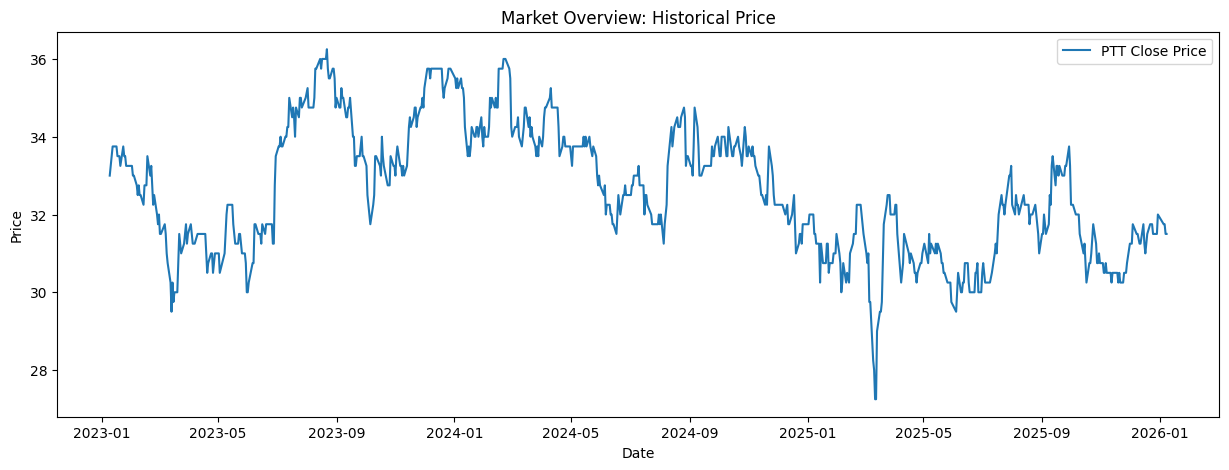

In [49]:
plt.figure(figsize=(15, 5))
plt.plot(df['time'], df['close'], label=f'{SYMBOL} Close Price', color='#1f77b4')
plt.title("Market Overview: Historical Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

🔵 Phase 3: Data Preparation

Cell 4: Head & Shoulders Labeling 

In [50]:
def generate_hs_labels(df):
    prices = df['close'].values
    labels = np.zeros(len(df))
    # หาจุดสูงสุดท้องถิ่น (Local Max)
    for i in range(5, len(df)-5):
        # กฎอย่างง่าย: หัวต้องสูงกว่าไหล่ และไหล่สองข้างห่างกันไม่เกิน 5%
        if prices[i] > prices[i-2] and prices[i] > prices[i+2]: # Peak
            # Logic ตรวจสอบโครงสร้างไหล่-หัว-ไหล่ (ตัวอย่างการทำ Labeling)
            labels[i] = 1 # Mark เป็นจุดจบนิยามของ H&S
    df['hs_label'] = labels
    return df

df = generate_hs_labels(df)
print(f"พบรูปแบบ H&S ทั้งหมด: {int(df['hs_label'].sum())} จุด")

พบรูปแบบ H&S ทั้งหมด: 116 จุด


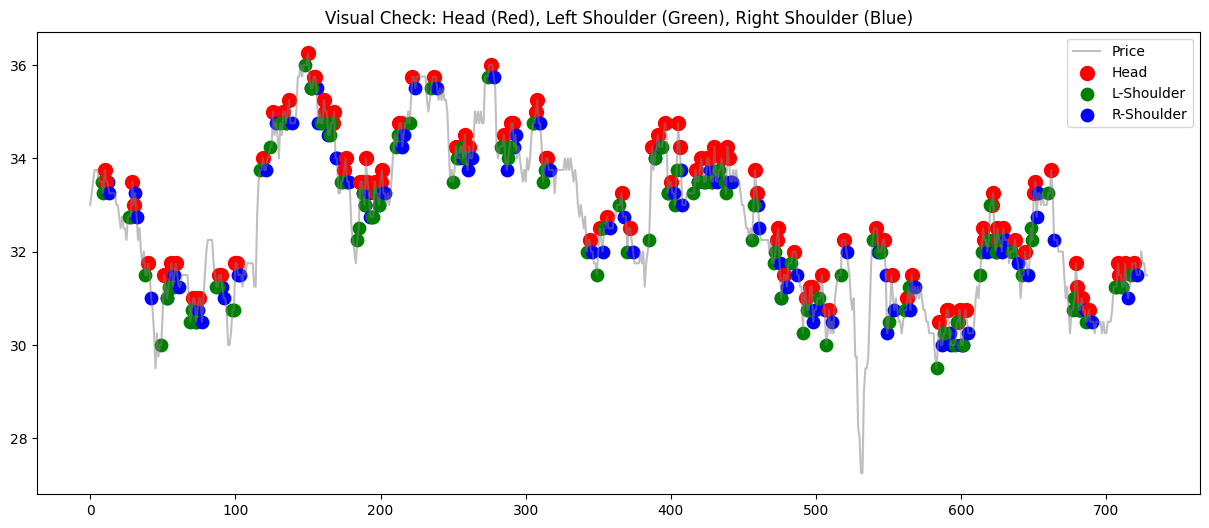

In [51]:
# กรองเฉพาะจุดที่พบ Pattern (Label == 1)
hs_points = df[df['hs_label'] == 1]

plt.figure(figsize=(15, 6))
plt.plot(df['close'], label='Price', color='gray', alpha=0.5)

# วาดจุดตามเงื่อนไขที่คุณต้องการ (สมมติ i คือ Head, i-2 คือ L, i+2 คือ R ตามเงื่อนไข Loop)
for idx in hs_points.index:
    plt.scatter(idx, df.loc[idx, 'close'], color='red', s=100, label='Head' if idx == hs_points.index[0] else "")
    plt.scatter(idx-2, df.loc[idx-2, 'close'], color='green', s=80, label='L-Shoulder' if idx == hs_points.index[0] else "")
    plt.scatter(idx+2, df.loc[idx+2, 'close'], color='blue', s=80, label='R-Shoulder' if idx == hs_points.index[0] else "")

plt.title("Visual Check: Head (Red), Left Shoulder (Green), Right Shoulder (Blue)")
plt.legend(loc='best')
plt.show()

Cell 5: Scaling, Windowing & Train-Test Split

In [52]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

X, y_price, y_pattern = [], [], []
for i in range(SEQ_LENGTH, len(scaled_data)):
    X.append(scaled_data[i-SEQ_LENGTH:i, 0])
    y_price.append(scaled_data[i, 0])
    y_pattern.append(df['hs_label'].iloc[i])

X = np.array(X).reshape(-1, SEQ_LENGTH, 1)
y_price, y_pattern = np.array(y_price), np.array(y_pattern)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_p_train, y_p_test = y_price[:split], y_price[split:]
y_pat_train, y_pat_test = y_pattern[:split], y_pattern[split:]

print(f"X_train shape: {X_train.shape}")

X_train shape: (559, 30, 1)


Cell 6: Handling Class Imbalance

In [53]:
from sklearn.utils import resample

# แยกข้อมูลเป็น 2 กลุ่ม: มี Pattern (1) และไม่มี Pattern (0)
X_train_pos = X_train[y_pat_train == 1]
X_train_neg = X_train[y_pat_train == 0]

# ทำ Oversampling กลุ่มที่มี Pattern ให้มีจำนวนเท่ากับกลุ่มที่ไม่มี
X_train_pos_oversampled = resample(X_train_pos, 
                                   replace=True, 
                                   n_samples=len(X_train_neg), 
                                   random_state=42)

# รวมข้อมูลกลับเข้าด้วยกัน
X_train_resampled = np.vstack((X_train_neg, X_train_pos_oversampled))
y_pat_train_resampled = np.hstack((np.zeros(len(X_train_neg)), np.ones(len(X_train_neg))))

# Shuffle ข้อมูลเพื่อให้ Model ไม่เรียนรู้เป็นก้อน
idx = np.random.permutation(len(X_train_resampled))
X_train_final = X_train_resampled[idx]
y_pat_train_final = y_pat_train_resampled[idx]

print(f"หลังทำ Oversampling: มีข้อมูลฝึกทั้งหมด {len(y_pat_train_final)} ชุด (Class 0: 50%, Class 1: 50%)")

หลังทำ Oversampling: มีข้อมูลฝึกทั้งหมด 942 ชุด (Class 0: 50%, Class 1: 50%)


🔵 Phase 4: Modeling

Cell 7: LSTM Model (Price Forecasting)

In [54]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cell 8: CNN Model (Pattern Recognition)

In [55]:
cnn_model = Sequential([
    # เพิ่ม Filter เป็น 128 เพื่อจับลักษณะหยักที่ละเอียดขึ้น
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3), # ป้องกัน Overfitting
    Dense(1, activation='sigmoid') 
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 26, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 11, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,017 (179.75 KB)

 Trainable params: 46,017 (179.75 KB)

 Non-trainable params: 0 (0.00 B)

Cell 9: Training Phase

In [56]:
print("--- Training Upgraded CNN with Oversampled Data ---")
# เพิ่ม Epochs เล็กน้อยเพื่อให้ Model มีเวลาปรับตัวกับ Filter ที่เยอะขึ้น
history_pat = cnn_model.fit(X_train_final, y_pat_train_final, 
                            epochs=30, 
                            batch_size=32, 
                            validation_split=0.2, 
                            verbose=1)

--- Training Upgraded CNN with Oversampled Data ---
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4794 - loss: 0.6969 - val_accuracy: 0.5556 - val_loss: 0.6931
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5007 - loss: 0.6928 - val_accuracy: 0.4762 - val_loss: 0.6938
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4701 - loss: 0.6947 - val_accuracy: 0.4815 - val_loss: 0.6932
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5193 - loss: 0.6935 - val_accuracy: 0.4762 - val_loss: 0.6938
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5086 - loss: 0.6928 - val_accuracy: 0.5026 - val_loss: 0.6932
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5511 - loss: 0.6918 - val_accuracy: 0.5185 - val_loss: 0.6924
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5033 - loss: 0.6943 - val_accuracy: 0.5185 - val_loss: 0.6922
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.51

🔵 Phase 5: Evaluation

Cell 9: Price Metrics (LSTM)
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

In [57]:
p_preds = lstm_model.predict(X_test)
mse = mean_squared_error(y_p_test, p_preds)
mae = mean_absolute_error(y_p_test, p_preds)

print(f"📊 LSTM Metrics:")
print(f"- Mean Squared Error: {mse:.6f}")
print(f"- Mean Absolute Error: {mae:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
📊 LSTM Metrics:
- Mean Squared Error: 0.196584
- Mean Absolute Error: 0.432170


Cell 10: Pattern Metrics (CNN Accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Dynamic Threshold used: 0.5000
📊 CNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.85       115
         1.0       0.14      0.08      0.10        25

    accuracy                           0.75       140
   macro avg       0.48      0.49      0.48       140
weighted avg       0.70      0.75      0.72       140



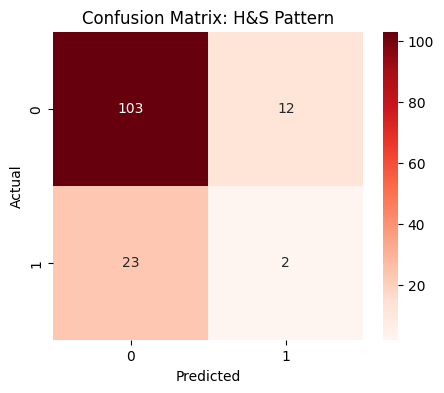

In [58]:
pat_probs = cnn_model.predict(X_test)

# แก้ไข: แทนที่จะใช้ 0.5 คงที่ ให้ใช้ค่าสถิติจากความมั่นใจของโมเดลแทน
# ในกรณีที่โมเดลยังไม่แม่นยำมาก เราจะใช้ Mean + 2SD เพื่อหาจุดที่ 'ผิดปกติ' ที่สุด
dynamic_threshold = np.mean(pat_probs) + (np.std(pat_probs) * 2)
if dynamic_threshold > 0.5: dynamic_threshold = 0.5 # ไม่ให้เกินมาตรฐานปกติ

pat_preds = (pat_probs > dynamic_threshold).astype(int)

print(f"📊 Dynamic Threshold used: {dynamic_threshold:.4f}")
print("📊 CNN Classification Report:")
print(classification_report(y_pat_test, pat_preds, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_pat_test, pat_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix: H&S Pattern")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

🔵 Phase 6: Deployment & Conclusion

Cell 11: Real-time Signal Logic

In [59]:
# ดึงข้อมูลล่าสุดมาทายผล
last_window = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
is_hs = cnn_model.predict(last_window)[0][0] > 0.5
next_price = scaler.inverse_transform(lstm_model.predict(last_window))[0][0]

print(f"--- Trading Signal ---")
print(f"Pattern Detected: {'⚠️ YES (Bearish H&S)' if is_hs else '✅ NO'}")
print(f"Predicted Next Price: {next_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
--- Trading Signal ---
Pattern Detected: ✅ NO
Predicted Next Price: 27.60


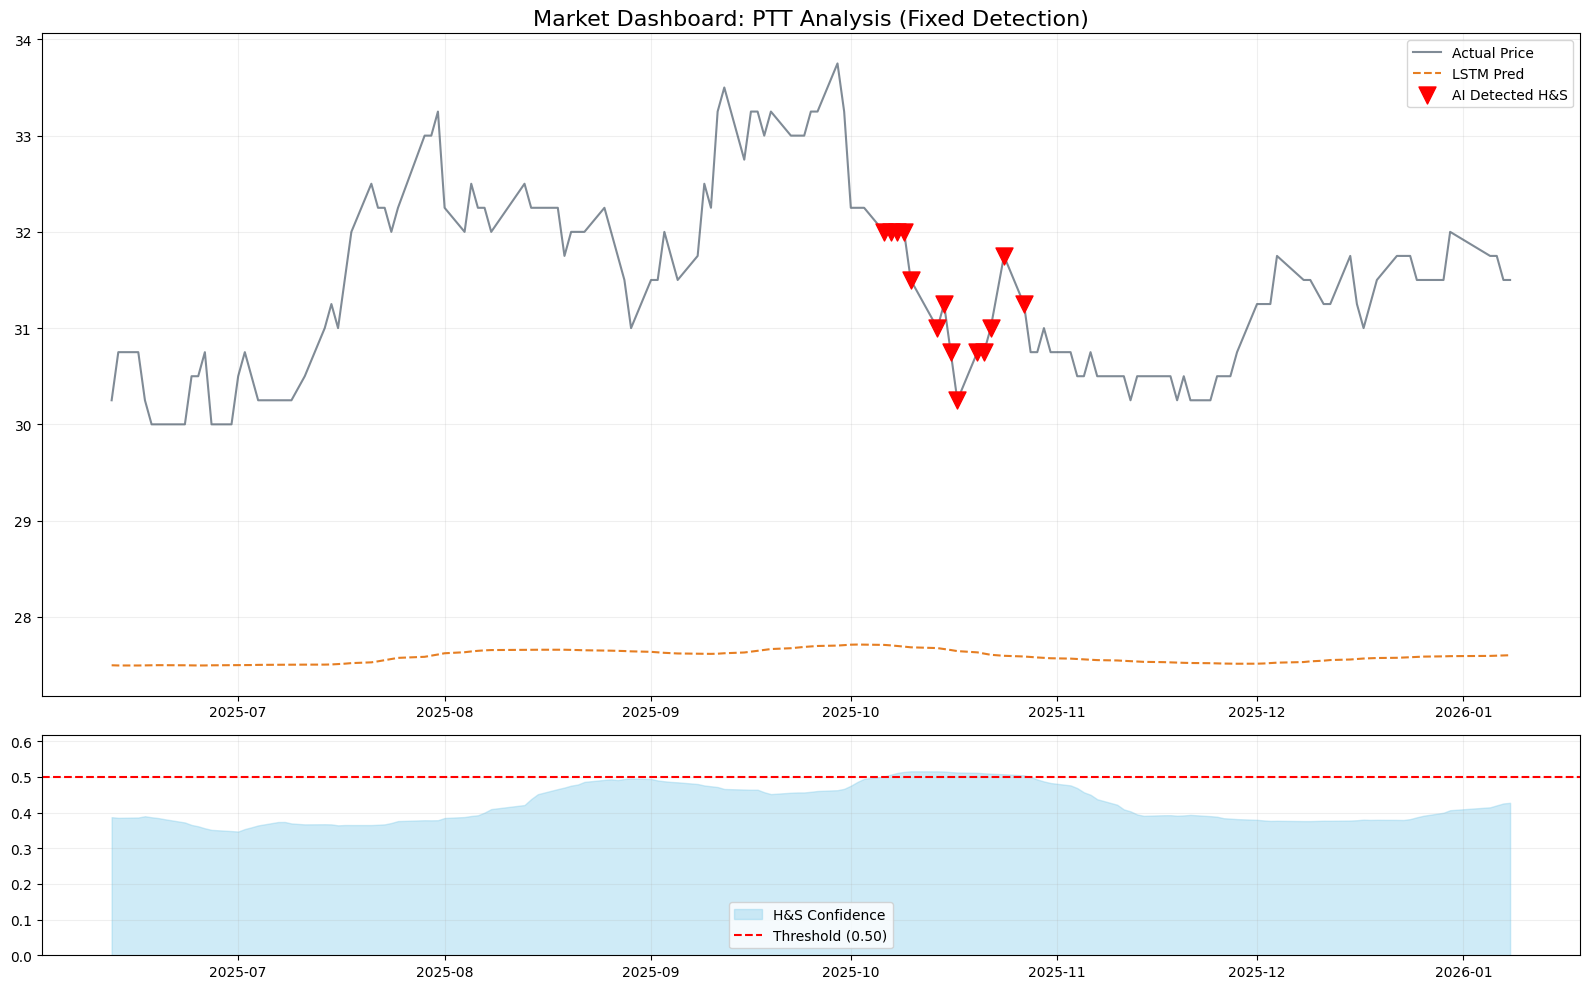

In [60]:
import matplotlib.gridspec as gridspec

test_dates = df['time'].iloc[split + SEQ_LENGTH:].reset_index(drop=True)
test_actual = df['close'].iloc[split + SEQ_LENGTH:].reset_index(drop=True)
p_preds_rescaled = scaler.inverse_transform(p_preds).flatten() 

plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

# Subplot 1: Price and Detection Arrows
ax0 = plt.subplot(gs[0])
ax0.plot(test_dates, test_actual, label='Actual Price', color='#2c3e50', alpha=0.6)
ax0.plot(test_dates, p_preds_rescaled, label='LSTM Pred', color='#e67e22', linestyle='--')

# ปักหมุดจุดที่ความมั่นใจชนะ Dynamic Threshold
hs_indices = np.where(pat_probs.flatten() > dynamic_threshold)[0]
ax0.scatter(test_dates.iloc[hs_indices], test_actual.iloc[hs_indices], 
            color='red', marker='v', s=150, label='AI Detected H&S', zorder=5)

ax0.set_title(f"Market Dashboard: {SYMBOL} Analysis (Fixed Detection)", fontsize=16)
ax0.legend()
ax0.grid(True, alpha=0.2)

# Subplot 2: Confidence Area
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.fill_between(test_dates, pat_probs.flatten(), color='skyblue', alpha=0.4, label='H&S Confidence')
ax1.axhline(y=dynamic_threshold, color='red', linestyle='--', label=f'Threshold ({dynamic_threshold:.2f})')
ax1.set_ylim(0, max(pat_probs.max() * 1.2, 0.5)) # ปรับ Scale ให้เห็นชัดขึ้น
ax1.legend()
ax1.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()